In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.layers import Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Cargar datos estructurados
import h5py
import numpy as np

# Abrir archivo .mat versión 7.3
with h5py.File("tot_data.mat", "r") as f:
    # El nombre de la variable puede variar; usamos 'x' como nombre real detectado en tu archivo
    raw_data = f['x'][:]  # Esto da forma (7, 511700)

# Transponer para tener la forma correcta (511700, 7)


# Columnas relevantes
time = raw_data[:, 0]
freq = raw_data[:, 1]
rocof = raw_data[:, 2]
perturbation = raw_data[:, 3]
inertia = raw_data[:, 4]


In [2]:
# Crear secuencias por bloques de inercia
def preparar_datos_por_inercia(freq, rocof, inertia, window_size=100, step_size=1, test_size=0.2, random_state=42):
    X_all, y_all = [], []

    unique_inertias = np.unique(inertia)
    for val in unique_inertias:
        mask = inertia == val
        freq_block = freq[mask]
        rocof_block = rocof[mask]
        y_block = inertia[mask]

        for i in range(0, len(freq_block) - window_size, step_size):
            X_seq = np.stack([freq_block[i:i+window_size], rocof_block[i:i+window_size]], axis=1)
            X_all.append(X_seq)
            y_all.append(y_block[i + window_size])

    X_all = np.array(X_all)
    y_all = np.array(y_all)

    # División estratificada por inercia
    stratify_labels = y_all.flatten()
    return train_test_split(X_all, y_all, test_size=test_size, stratify=stratify_labels, random_state=random_state)

In [3]:
def train_and_plot(model, model_name):
    model.compile(optimizer='adam', loss='mae')
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                        validation_split=0.2, verbose=0, callbacks=[early_stop])
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"{model_name} MAE: {mae:.4f}")

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} - Entrenamiento")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)

    # 🧮 Mostrar MAE en recuadro
    mae_val_final = history.history['val_loss'][-1]
    plt.text(0.95, 0.95,
             f"MAE final: {mae_val_final:.4f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    # 💾 Guardar como archivo
    plt.savefig(f"{model_name.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

3193/3193 ━━━━━━━━━━━━━━━━━━━━ 3s 875us/step
CNN (kernels=7,5) con window size = 0.25s MAE: 0.4555


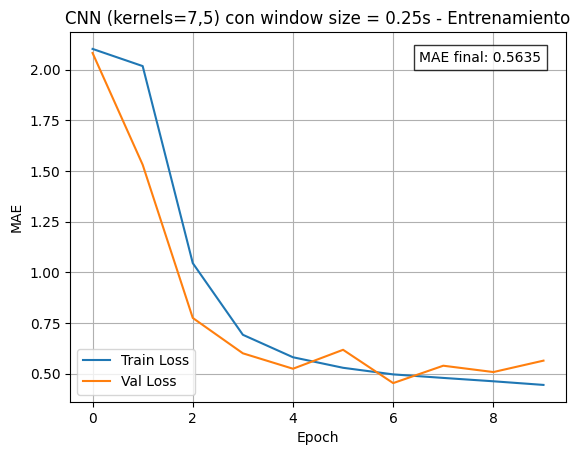

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
CNN (kernels=7,5) con window size = 0.50s MAE: 0.1542


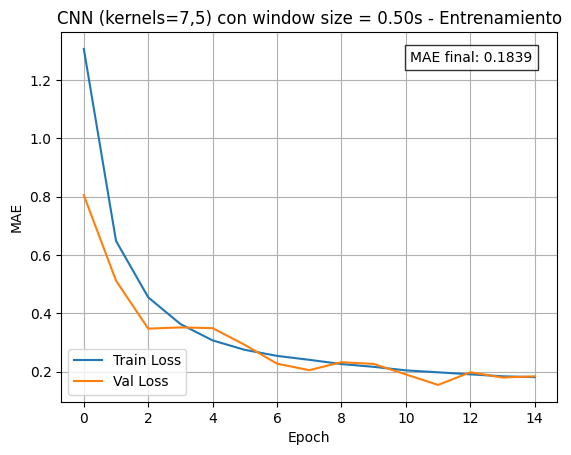

3177/3177 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CNN (kernels=7,5) con window size = 1.00s MAE: 0.0685


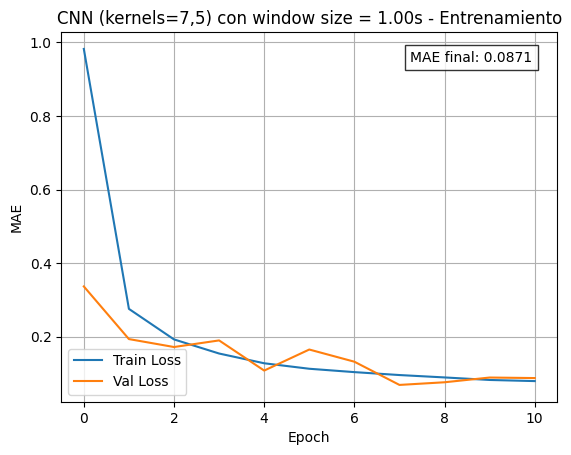

3156/3156 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
CNN (kernels=7,5) con window size = 2.00s MAE: 0.0303


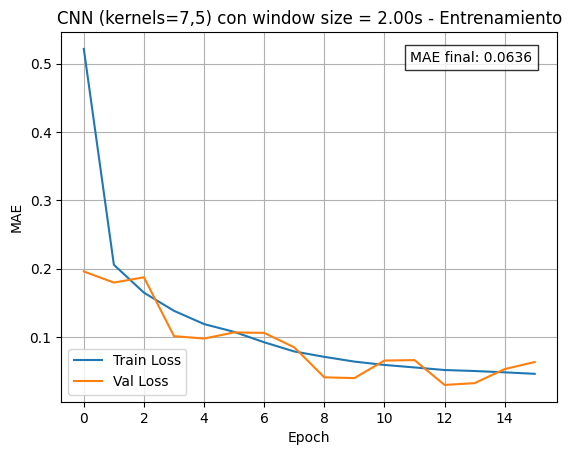

In [4]:
sampling_rate = 200  # 200 muestras por segundo
window_sizes = [50, 100, 200, 400]
resultados = []

for ws in window_sizes:
    tiempo_segundos = ws / sampling_rate  # convertir a segundos
    X_train, X_test, y_train, y_test = preparar_datos_por_inercia(freq, rocof, inertia, window_size=ws)
    
    for k1, k2 in [(7, 5)]:
        model_cnn = Sequential([
            Input(shape=(ws, 2)),
            Conv1D(64, kernel_size=k1, activation='relu'),
            Conv1D(32, kernel_size=k2, activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(1)
        ])
        train_and_plot(model_cnn, f"CNN (kernels={k1},{k2}) con window size = {tiempo_segundos:.2f}s")

3193/3193 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Híbrido CNN-LSTM 5,3,con window size = 0.25s MAE: 0.3171


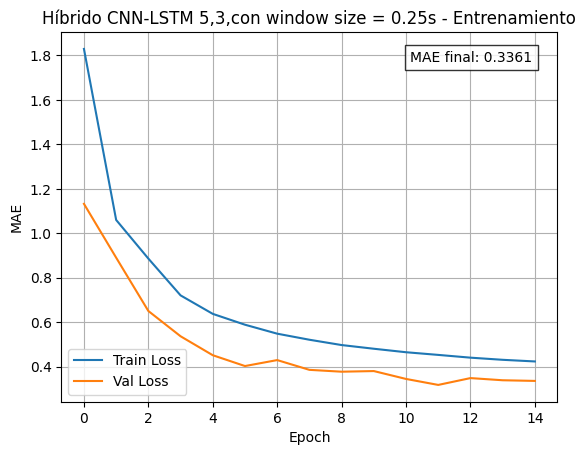

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Híbrido CNN-LSTM 5,3,con window size = 0.50s MAE: 0.1127


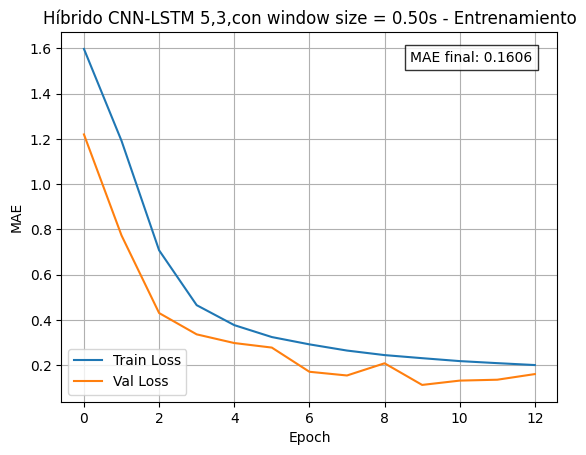

3177/3177 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step
Híbrido CNN-LSTM 5,3,con window size = 1.00s MAE: 0.0594


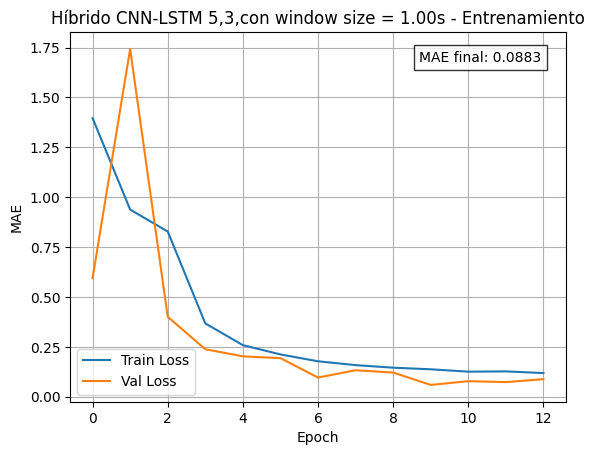

3156/3156 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step
Híbrido CNN-LSTM 5,3,con window size = 2.00s MAE: 0.0325


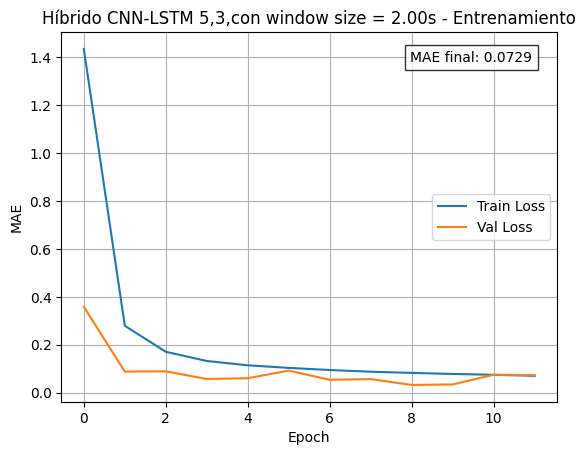

In [7]:
window_sizes = [50, 100, 200, 400]
resultados = []
sampling_rate = 200  # 200 muestras por segundo
for ws in window_sizes:
    X_train, X_test, y_train, y_test = preparar_datos_por_inercia(freq, rocof, inertia, window_size=ws)
    tiempo_segundos = ws / sampling_rate  # convertir a segundos
    for k1, k2 in [(5, 3)]:
        model_hybrid = Sequential([
            Input(shape=(ws, 2)),

            # Primera capa convolucional
            Conv1D(64, kernel_size=k1, activation='relu'),
            MaxPooling1D(),

            # Segunda capa convolucional (más pequeña)
            Conv1D(32, kernel_size=k2, activation='relu'),
            MaxPooling1D(),

            # Capa LSTM más compleja
            LSTM(64, dropout=0.3, recurrent_dropout=0.2),

            # Capa densa intermedia
            Dense(64, activation='relu'),

            # Capa de salida
            Dense(1)
        ])
        train_and_plot(model_hybrid, f"Híbrido CNN-LSTM {k1},{k2},con window size = {tiempo_segundos:.2f}s")


3193/3193 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CNN (kernels=7+5+3), con window size = 0.25s MAE: 0.1654


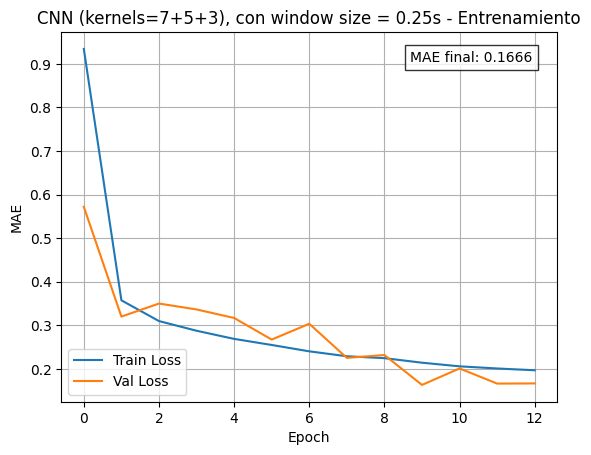

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
CNN (kernels=7+5+3), con window size = 0.50s MAE: 0.0767


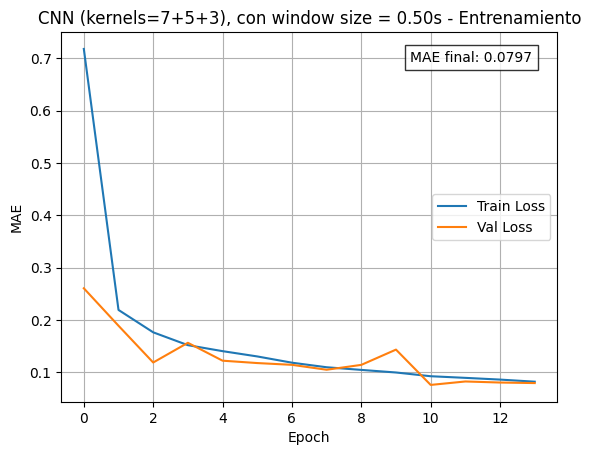

3177/3177 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
CNN (kernels=7+5+3), con window size = 1.00s MAE: 2.1182


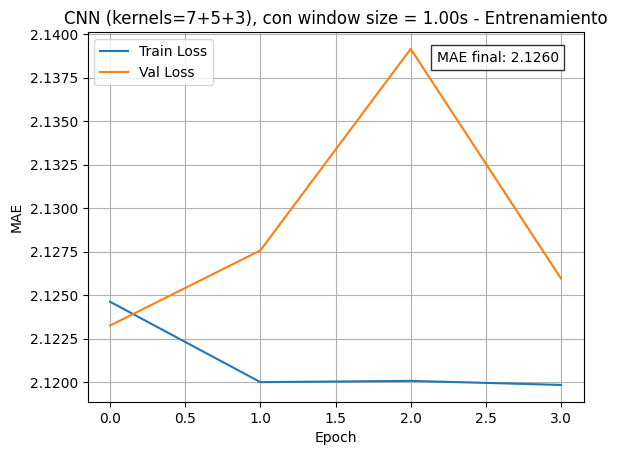

3156/3156 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
CNN (kernels=7+5+3), con window size = 2.00s MAE: 2.1180


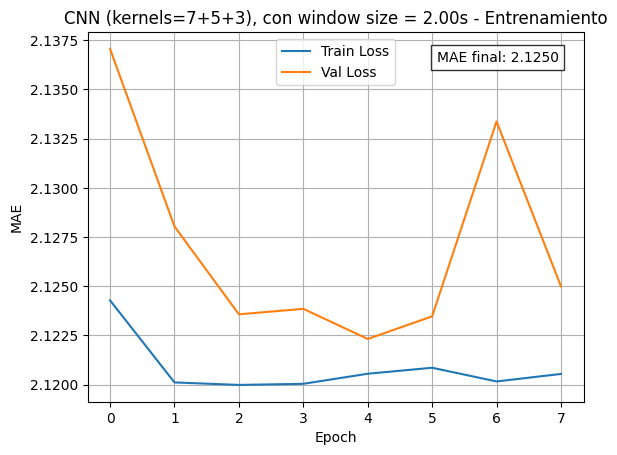

In [5]:
window_sizes = [50, 100, 200,400]
resultados = []
sampling_rate = 200  # 200 muestras por segundo
for ws in window_sizes:
    X_train, X_test, y_train, y_test = preparar_datos_por_inercia(freq, rocof, inertia, window_size=ws)    
    tiempo_segundos = ws / sampling_rate  # convertir a segundos
    for k1, k2,k3 in [ (7, 5, 3)]:
            model_cnn = Sequential([
                Input(shape=(ws, 2)),
                Conv1D(128, kernel_size=k1, activation='relu'),
                Conv1D(64, kernel_size=k2, activation='relu'),
                Conv1D(32, kernel_size=k3, activation='relu'),
                MaxPooling1D(),
                Flatten(),
                Dense(128, activation='tanh'),
                Dense(64, activation='tanh'),
                Dense(1)
            ])
            train_and_plot(model_cnn, f"CNN (kernels={k1}+{k2}+{k3}), con window size = {tiempo_segundos:.2f}s")


3193/3193 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CNN (kernels=5,3,2,2), con window size = 0.25s MAE: 0.1811


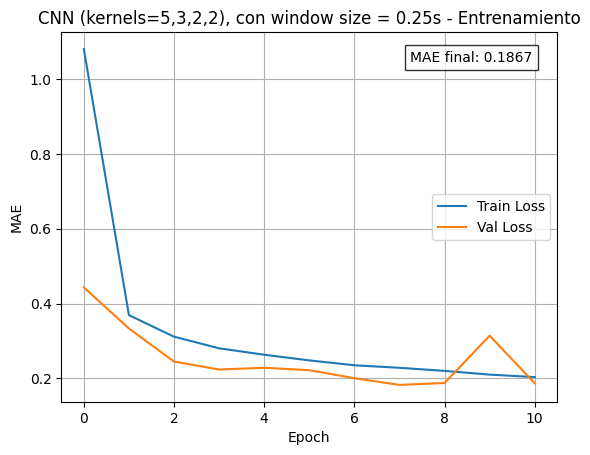

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
CNN (kernels=5,3,2,2), con window size = 0.50s MAE: 0.0858


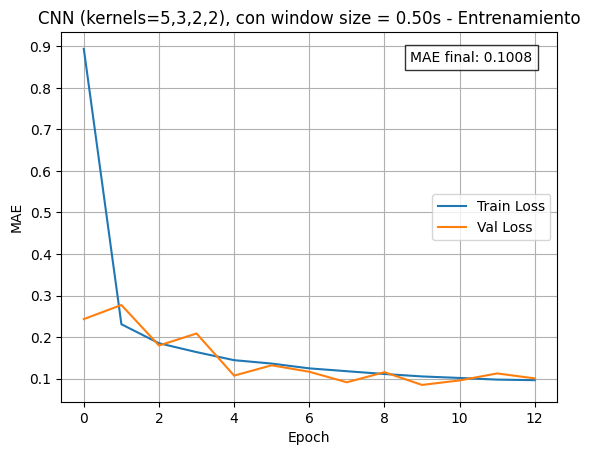

3177/3177 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
CNN (kernels=5,3,2,2), con window size = 1.00s MAE: 0.0447


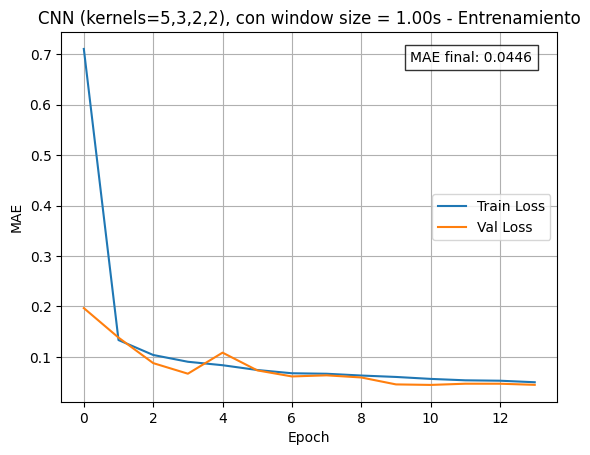

3156/3156 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
CNN (kernels=5,3,2,2), con window size = 2.00s MAE: 0.0223


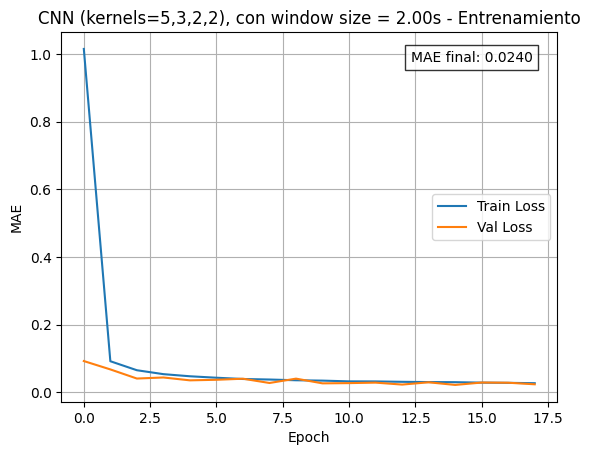

In [6]:
window_sizes = [50, 100, 200, 400]
resultados = []
sampling_rate = 200  # 200 muestras por segundo
for ws in window_sizes:
    X_train, X_test, y_train, y_test = preparar_datos_por_inercia(freq, rocof, inertia, window_size=ws)
    tiempo_segundos = ws / sampling_rate  # convertir a segundos
    for k1, k2,k3,k4 in [ (5, 3, 2, 2 )]:
        model_cnn = Sequential([
            Input(shape=(ws, 2)),
            Conv1D(128, kernel_size=k1, activation='relu'),
            Conv1D(64, kernel_size=k2, activation='relu'),
            Conv1D(32, kernel_size=k3, activation='relu'),
            Conv1D(32, kernel_size=k4, activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(128, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(1)
        ])
        train_and_plot(model_cnn, f"CNN (kernels={k1},{k2},{k3},{k4}), con window size = {tiempo_segundos:.2f}s")

In [ ]:
df_filtrado = df[(df['time'] >= 30.0) & (df['time'] <= 30.3)].reset_index(drop=True)